In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import yaml

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/data/projects/Comet/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [29]:
fname = path_to_data + 'downloads/ar_impact_info.csv'
df = pd.read_csv(fname)
# df = df.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9','Unnamed: 10', 'Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14'], axis=1)
df = df.set_index(pd.to_datetime(df['Impact dates']))
start_date = '2000-01-01'
end_date = '2019-12-31'
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]
## fix names of stations to match ASOS/COOP station ID
df['Location'] = df['Location'].replace({'JNNA2': 'PAJN', 'PECA2': 'COOPPECA2', 
                        'HCSA2': 'COOPHCSA2', 'AHNA2': 'COOPAHNA2',
                        'Thorne Bay': 'PAKW', 'Thorne Bay/PAKW': 'PAKW',
                        'Staney/PAKW': 'PAKW', 'HOOA2': 'COOPHOOA2',
                        np.nan: 'PAJN'})

df

,Last Date,Location,Total Hours,Total IVT,Max IVT,Total Precip,Avg. Direction,Return Period,1h ARI,3h ARI,...,1d ARI,Impact Level,Impact dates,Impact,Impact Information,Location.1,Impact Source,Notes,Wick Precip,Wick Return
Impact dates,,,,,,,,,,,,,,,,,,,,,
2019-12-27,NaN,PAKT,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,...,1.00,2.00,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",PAKT,ARDAT,NaN,NaN,NaN
2019-12-27,NaN,KTNA2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.00,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",KTNA2,ARDAT,NaN,NaN,NaN
2019-11-22,20191123_00Z,KTNA2,24.00,849.10,443.36,NaN,232.01,NaN,NaN,NaN,...,NaN,1.00,11/22/2019,Flood stage; action stage,Ketchikan creek at 3rd highest crest; Thorne r...,KTNA2,AHPS,NaN,NaN,NaN
2019-11-22,20191123_00Z,PAKW,24.00,724.78,425.21,1.70,232.16,NaN,1.00,1.00,...,1.00,0.00,11/22/2019,Action stage,Thorne River at 8th highest overflow,PAKW,AHPS,NaN,NaN,NaN
2019-11-17,20191117_00Z,PAJN,24.00,591.23,315.56,1.73,179.04,NaN,1.00,1.00,...,1.00,0.00,11/17/2019,Action stage,Jordan Creek at 11th highest crest,PAJN,AHPS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-07-24,20000725_00Z,PAKT,36.00,"1,335.43",581.58,6.01,178.67,1,1.00,1.00,...,1.00,2.00,07/24/2000,Residential and street flooding',"Basements flooded along water street, small cr...",PAKT,APRFC,23rd had the 24th highest precip at 4.72,NaN,NaN
2000-07-24,20000725_00Z,KTNA2,36.00,"1,299.94",584.26,2.17,179.24,<1,NaN,NaN,...,NaN,2.00,07/24/2000,Residential and street flooding',"Basements flooded along water street, small cr...",KTNA2,APRFC,This event followed 2 ar events,NaN,NaN
2000-07-13,NaN,PAYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.00,1.00,07/13/2000,"Flooding, action stage","Alsek at 10th highest overflow, minor flooding...",PAYA,NWS,This is not in AR database; 07/12/2000 - 07/13...,NaN,NaN


In [30]:
## read .yaml file with station information
yaml_doc = '../data/ASOS_station_info.yaml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

## build empty dataframes
station_lst = []
for i, stationID in enumerate(config):
    station_lst.append(stationID)
df_filtered = df[~df['Location'].isin(station_lst)]
df_filtered['Location'].unique()

array([], dtype=object)

In [31]:
df.groupby('Impact Level').size()

Impact Level
0.00    106
1.00     51
2.00     77
3.00     26
4.00      5
5.00     14
dtype: int64

In [32]:
test = df.groupby([df.index.month, 'Impact Level']).size()
test

Impact dates  Impact Level
1             0.00             6
              1.00             1
              2.00            11
              4.00             2
2             0.00             3
3             0.00             1
              2.00             1
              3.00             1
5             0.00             2
              2.00             1
6             0.00            10
              1.00             5
              2.00             3
7             0.00            13
              1.00             3
              2.00             9
              3.00             4
8             0.00            15
              1.00            13
              2.00            17
              3.00             6
              5.00             1
9             0.00            34
              1.00            15
              2.00            22
              3.00             4
10            0.00            10
              1.00             9
              2.00             3
              3.

<AxesSubplot:xlabel='Impact dates'>

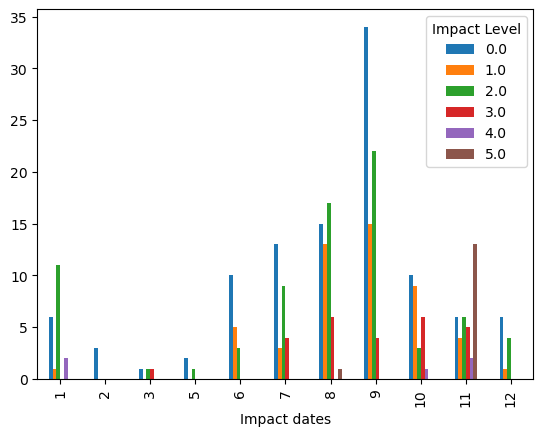

In [33]:
test.unstack('Impact Level').plot.bar()

In [34]:
keys = df['Location'].unique()
print(keys)
## loop through each row in impact dataframe
for i, key in enumerate(keys):
    subset_df = df.loc['Location' == key]
    
    ## grab the AR df for that station
    
## if 

['PAKT' 'KTNA2' 'PAKW' 'PAJN' 'PAGS' 'COOPHOOA2' 'PAPG' 'PASI' 'PAGY'
 'COOPHCSA2' 'COOPAHNA2' 'PAHN' 'PAYA' 'PAWG' 'COOPPECA2']


In [40]:
df.loc[(df['Location'] == 'PAKT')]

,Last Date,Location,Total Hours,Total IVT,Max IVT,Total Precip,Avg. Direction,Return Period,1h ARI,3h ARI,...,1d ARI,Impact Level,Impact dates,Impact,Impact Information,Location.1,Impact Source,Notes,Wick Precip,Wick Return
Impact dates,,,,,,,,,,,,,,,,,,,,,
2019-12-27,NaN,PAKT,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,...,1.00,2.00,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",PAKT,ARDAT,NaN,NaN,NaN
2019-10-15,20191016_12Z,PAKT,48.00,"1,891.71",585.61,8.45,176.05,NaN,1.00,1.00,...,5.00,1.00,10/15/2019,Lake Flooding,"minor flooding at ward lake, some trails and c...",PAKT,APRFC,The 16th had the 27th highest precip,NaN,NaN
2018-12-09,20181211_12Z,PAKT,24.00,775.85,454.33,NaN,191.22,NaN,1.00,1.00,...,1.00,0.00,12/09/2018,Action flooding,Ketchikan creek at 5th most overflow,PAKT,AHPS,NaN,NaN,NaN
2017-08-28,20170827_12Z,PAKT,60.00,"1,585.34",365.51,2.60,209.90,<1,1.00,1.00,...,1.00,0.00,08/28/2017,Action flooding,Lower Ketchikan lake at the 5th most overflow,PAKT,AHPS,NaN,NaN,NaN
2017-08-22,20170822_12Z,PAKT,48.00,"2,147.98",810.80,7.12,211.92,1-2,2.00,5.00,...,5.00,2.00,08/22/2017,Flooding,"Minor flooding of ward lake ,river. Water into...",PAKT,"ARDAT, APRFC",The 22nd had the 9th highest precip amounts; 8...,NaN,NaN
2016-02-26,20160226_12Z,PAKT,36.00,"1,126.07",394.31,7.00,180.47,1-2,1.00,1.00,...,2.00,0.00,02/26/2016,Action flooding,Lower Ketchikan Lake at 6th most overflow,PAKT,AHPS,The 26th had the 8th highest precip in Ketchikan,NaN,NaN
2015-10-21,20151021_12Z,PAKT,36.00,"1,300.23",610.47,5.75,210.95,1-2,1.00,1.00,...,2.00,0.00,10/21/2015,Action flooding,Thorne River at 7th most overflow,PAKT,AHPS,The 21st had the 11th highest precip in Ketchikan,NaN,NaN
2015-01-22,20150122_00Z,PAKT,36.00,"1,638.13",627.78,9.93,195.52,2-5,1.00,1.00,...,2.00,2.00,01/22/2015,Flooding,Flooding in Ketchikan,PAKT,HYDRO,& The 21st had 5th highest precip in Ketchikan...,NaN,NaN
2014-03-12,NaN,PAKT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.00,03/12/2014,"Street flooding, Major flooding of Thorne Rive...","Flooding of the Thorne River on POW, flooding ...",PAKT,"AHPS, HYDRO",NO ASOS AR DATA for 03/12/2014 event except th...,NaN,NaN
